In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cvxpy as cp

La libreria cvxpy non è un ottimizzatore, ma un layer che ci permette di esprimere i problemi convessi in modo naturale.
Creiamo un primo esempio di problema convesso, spiegiamo il funzionamento del codice:

* `x = cp.Variable(1)` identifica una variabile da ottimizzare 1 rappresenta la dimensione  
* `cp.Minimize(x ** 2 - 6 * x + 10)` è la funzione obiettivo da minimizzare
* nella riga sucessiva vengono definiti i vincoli a cui la variabile deve sottostare

In [3]:
x = cp.Variable(1)      
objective = cp.Minimize(x ** 2 - 6 * x + 10)
constraints = [x >= 4, x <= 10]
prob = cp.Problem(objective, constraints)
result = prob.solve()
result

2.0

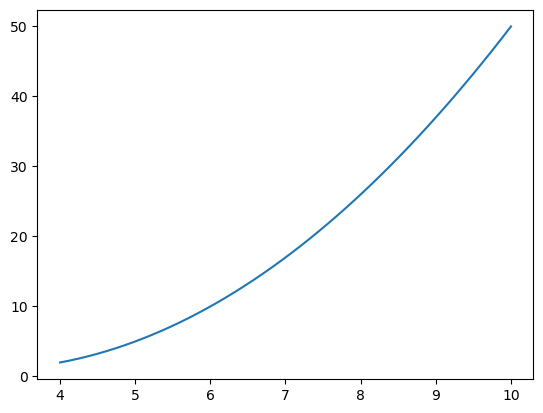

In [4]:
import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(4,10,50)
y = t ** 2 - 6 * t + 10
plt.plot(t,y)

per ottenere il valore minimo della variabile basta visualizzare la proprieta .value

In [5]:
x.value

array([4.])

Nel caso in cui tentassimo di ottimizzare un problema non convesso otterremo questo errore

In [6]:
x = cp.Variable(1)
objective = cp.Maximize((x - 1) * (x + 1) * (x + 2) * (x - 3))
constraints = []
 
prob = cp.Problem(objective, constraints)

try:
    result = prob.solve()
except Exception as e:
    print(e)

Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
(var33 + -1.0) @ (var33 + 1.0)


C:\ProgramData\anaconda3\Lib\site-packages\cvxpy\expressions\expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
C:\ProgramData\anaconda3\Lib\site-packages\cvxpy\expressions\expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.warn(msg, UserWarning)


## Modellare un problema media varianza

iniziamo con il modellare il problema media varianza :

$min(\omega^T \Sigma \omega)$

Con i seguenti vincoli:

$$\mu^T w \geq \bar{r}$$

$$ \textbf{1}^T w = 1 $$

In [7]:
import numpy as np

Sigma = np.matrix([[0.0225 , 0.0216 , 0.00075],   
                   [0.0216 , 0.0324 , 0.00045], 
                   [0.00075, 0.00045, 0.0025]])
mu = np.array([.06, .05, .03])
r = .055

N = len(mu)
w = cp.Variable(N)
objective = cp.Minimize(cp.quad_form(w, Sigma))
constraints = [w.T @ mu >= r, cp.sum(w) == 1, w>=0]
prob = cp.Problem(objective, constraints)
result = prob.solve()
result

0.015902777777777776

Alcune note su questo problema:

* `cp.quad_form` effettua il calcolo $\omega^T \Sigma \omega$
* `cp.sum` somma tutti i pesi della variabile

In [8]:
np.round(w.value,2)

array([0.83, 0.  , 0.17])

se volessimo imporre che il peso massimo di un asset non deve superare un certo valore basterebbe imporre che 
$$
\|\mathbf{x}\|_{\infty} = \max_i |x_i|
$$

In [9]:
constraints.append(cp.norm_inf(w) <= 0.5)

In [10]:
prob = cp.Problem(objective, constraints)
result = prob.solve()
np.round(w.value,2)

array([0.5, 0.5, 0. ])

Creiamo un portafoglio giocattolo e iniziamo a definire le classi base del nostro ottimizzatore

In [11]:
import pandas as pd

tickers = ['VTI', 'VEA', 'VWO', 'AGG', 'BNDX', 'EMB']
ers = pd.Series([.05, .05, .07, .03, .02, .04], tickers)
sigma = np.array(
    [[0.0287, 0.0250, 0.0267, 0.0000, 0.0002, 0.0084],
     [0.0250, 0.0281, 0.0288, 0.0003, 0.0002, 0.0092],
     [0.0267, 0.0288, 0.0414, 0.0005, 0.0004, 0.0112],
     [0.0000, 0.0003, 0.0005, 0.0017, 0.0008, 0.0019],
     [0.0002, 0.0002, 0.0004, 0.0008, 0.0010, 0.0011],
     [0.0084, 0.0092, 0.0112, 0.0019, 0.0011, 0.0083]])
sigma = pd.DataFrame(sigma, tickers, tickers)

Modelliamo i vincoli partendo da una classe base

In [12]:
from typing import Dict 
class Constraint:
 
    def generate_constraint(self, variables: Dict):
        """ Create the cvxpy Constraint
 
        :param variables: dictionary containing the cvxpy Variables for the
          problem
        :return: A cvxpy Constraint object representing the constraint
        """
        pass

Da questo impostiamo i vincoli di investimento totale e di posizione lunga

In [13]:
class LongOnlyConstraint(Constraint):
 
    def __init__(self):
        """ Constraint to enforce all portfolio weights are non-negative
        """
        pass
 
    def generate_constraint(self, variables: Dict):
        return variables['w'] >= 0
 
 
class FullInvestmentConstraint(Constraint):
 
    def __init__(self):
        """ Constraint to enforce the sum of the portfolio weights is one
        """
        pass
 
    def generate_constraint(self, variables: Dict):
        return cp.sum(variables['w']) == 1.0
 

Generiamo un ulteriore vincolo che a prima vista può sembrare un attimino più complicato impostiamo un portafgolio di riferimento `reference_weights`, volgiamo far si che la differenza della volatilità tra il portafoglio di riferimento e il nostro sia minima.

In [14]:
from typing import Union, List

class TrackingErrorConstraint(Constraint):
 
    def __init__(self,
                 asset_names: Union[List[str], pd.Index],
                 reference_weights: pd.Series,
                 sigma: pd.DataFrame,
                 upper_bound: float):
        """ Constraint on the tracking error between a subset of the
        portfolio and a set of target weights
 
        :param asset_names: Names of all assets in the problem
        :param reference_weights: Vector of target weights. Index should be
          a subset of asset_names
        :param sigma: Covariance matrix, indexed by asset_names
        :param upper_bound: Upper bound for the constraint, in units of
          volatility (standard deviation)
        """
        self.reference_weights = \
            reference_weights.reindex(asset_names).fillna(0)
        self.sigma = sigma
        self.upper_bound = upper_bound ** 2
 
    def generate_constraint(self, variables: Dict):
        w = variables['w']
        tv = cp.quad_form(w - self.reference_weights, self.sigma)
        return tv <= self.upper_bound

il `VolatilityConstraint` è una variante del `TrackingErrorConstraint` in cui il portafoglio di riferimento ha peso zero.

In [15]:
class VolatilityConstraint(TrackingErrorConstraint):
 
    def __init__(self,
                 asset_names: Union[List[str], pd.Index],
                 sigma: pd.DataFrame,
                 upper_bound: float):
        """ Constraint on the overall volatility of the portfolio
 
        :param asset_names: Names of all assets in the problem
        :param sigma: Covariance matrix, indexed by asset_names
        :param upper_bound: Upper bound for the constraint, in units of
          volatility (standard deviation)
        """
 
        zeros = pd.Series(np.zeros(len(asset_names)), asset_names)
        super(VolatilityConstraint, self).__init__(asset_names, zeros,
                                                   sigma, upper_bound)

In [16]:
class ReturnConstraint(Constraint):
    def __init__(self,
                 returns: pd.Series,
                 lower_bound: float):
        
        self.returns = returns
        self.lower_bound = lower_bound
    
    def generate_constraint(self, variables: Dict):
        w = variables['w']
        mu = self.returns
        return w.T @ mu >= self.lower_bound

Definiamo ora il nostro problema 

In [17]:
from math import inf
class MeanVarianceOpt:
 
    def __init__(self):
        self.asset_names = []
        self.variables = None
        self.prob = None
        self.has_solution = False
        self.solution = inf
 
    @staticmethod
    def _generate_constraints(variables: Dict,
                              constraints: List[Constraint]):
        return [c.generate_constraint(variables) for c in constraints]
 
    def solve(self):
        result = self.prob.solve()
        status = self.prob.status
        
        if status not in ["infeasible", "unbounded"]:
            print("Solution {0:.2} result status {1}".format(result,status))
            self.has_solution = True
            self.solution = result
        else:
            print("WARNING:  the optimizer did NOT exit successfully!!")
            
 
    def get_var(self, var_name: str):
        return pd.Series(self.variables[var_name].value, self.asset_names)

In [18]:
class MaxExpectedReturnOpt(MeanVarianceOpt):

    def __init__(self,
                 asset_names: Union[List[str], pd.Index],
                 constraints: List[Constraint],
                 ers: pd.Series):
        super().__init__()
        self.asset_names = asset_names
        variables = dict({'w': cp.Variable(len(ers))})

        cons = MeanVarianceOpt._generate_constraints(variables,
                                                     constraints)
        obj = cp.Maximize(ers.values.T @ variables['w'])
        self.variables = variables
        self.prob = cp.Problem(obj, cons)

In [19]:
class MinVarianceOpt(MeanVarianceOpt):
    def __init__(self,
                 asset_names: Union[List[str], pd.Index],
                 constraints: List[Constraint],
                 sigma: pd.DataFrame):
        
        super().__init__()
        self.asset_names = asset_names
        self.sigma = sigma
        variables = dict({'w': cp.Variable(len(asset_names))})

        cons = MeanVarianceOpt._generate_constraints(variables,
                                                     constraints)
        
        obj = cp.Minimize(cp.quad_form(variables['w'],self.sigma))
        self.variables = variables
        self.prob = cp.Problem(obj, cons)

In [24]:
cons = [LongOnlyConstraint(), FullInvestmentConstraint(),ReturnConstraint(ers, .03)]
o = MinVarianceOpt(ers.index, cons, sigma)
o.solve()
weights = np.round(o.get_var('w'), 6)
print(weights)

Solution 0.0013 result status optimal
VTI     0.034370
VEA     0.000000
VWO     0.050415
AGG     0.644817
BNDX    0.270398
EMB    -0.000000
dtype: float64
